# Predicting academic achievement from inattention (SNAP) - prediction

Arvid Lundervold, 29-Sep-2017

A.J. Lundervold, T. Bøe, A. Lundervold. *Inattention in primary school is not good for your future school achievement - a pattern classification study*. In rev.

Inattention in childhood is associated with academic problems later in life. The contribution of specific aspects of inattentive behaviour is, however, less known. We investigated feature importance of primary school teachers’ reports on nine aspects of inattentive behaviour, gender and age in predicting future academic achievement. Primary school teachers of n = 2491 children (7 - 9 years) rated nine items reflecting different aspects of inattentive behaviour in 2002. A mean academic achievement score at high school (2012) was available for each youth from an official school register. All scores were at a categorical level. Feature importances were assessed by using multinominal logistic regression, classification and regression trees analysis, and a random forest algorithm. Finally, a comprehensive pattern classification procedure using k-fold cross-validation was implemented. Overall, inattention was rated as more severe in boys, who also obtained lower academic achievement scores at high school than girls. Problems related to sustained attention and distractibility were together with age and gender defined as the most important features to predict future achievement scores. Using these four features as input to the collection of classifiers employing k-fold cross-validation for prediction of academic achievement level, we obtained classification accuracy, precision and recall that were clearly better than chance levels. Primary school teachers’ reports of problems related to sustained attention and distractibility were identified as the two most important features of inattentive behaviour predicting academic achievement in high school. Identification and follow-up procedures of primary school children showing these characteristics should be prioritised to prevent future academic failure.

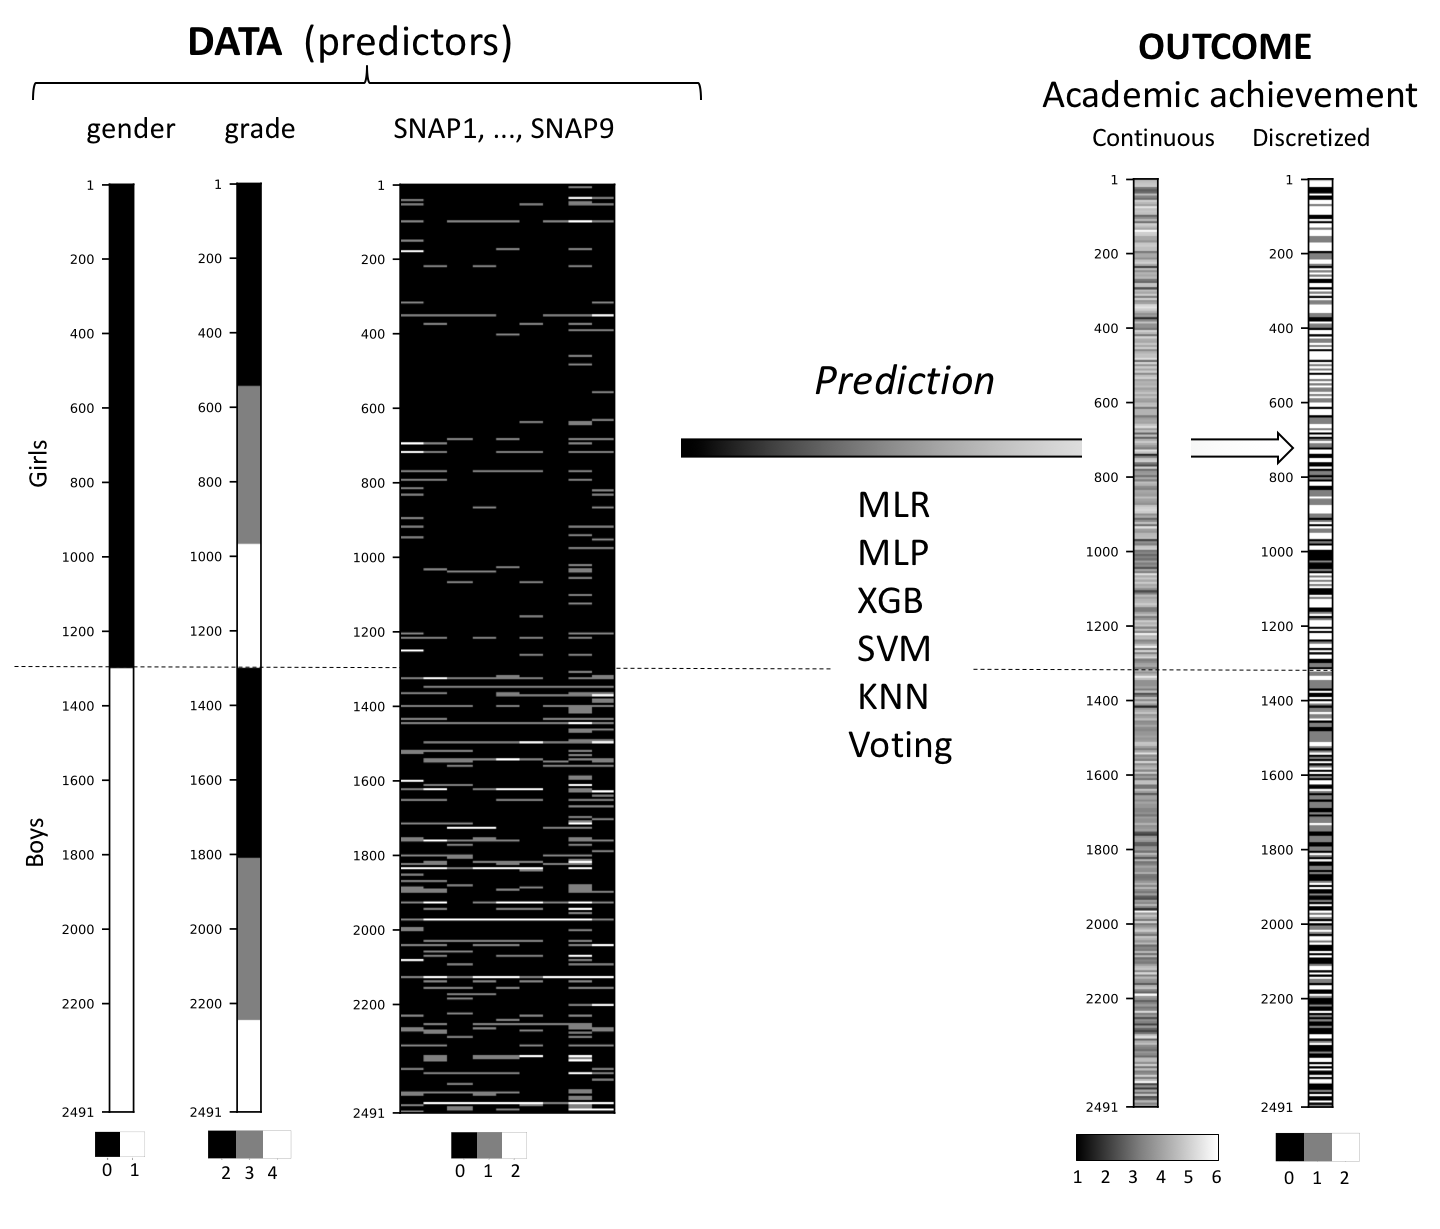

In [1]:
from IPython.display import Image
Image("../images/Data_to_classes_notebook_pptx.png")

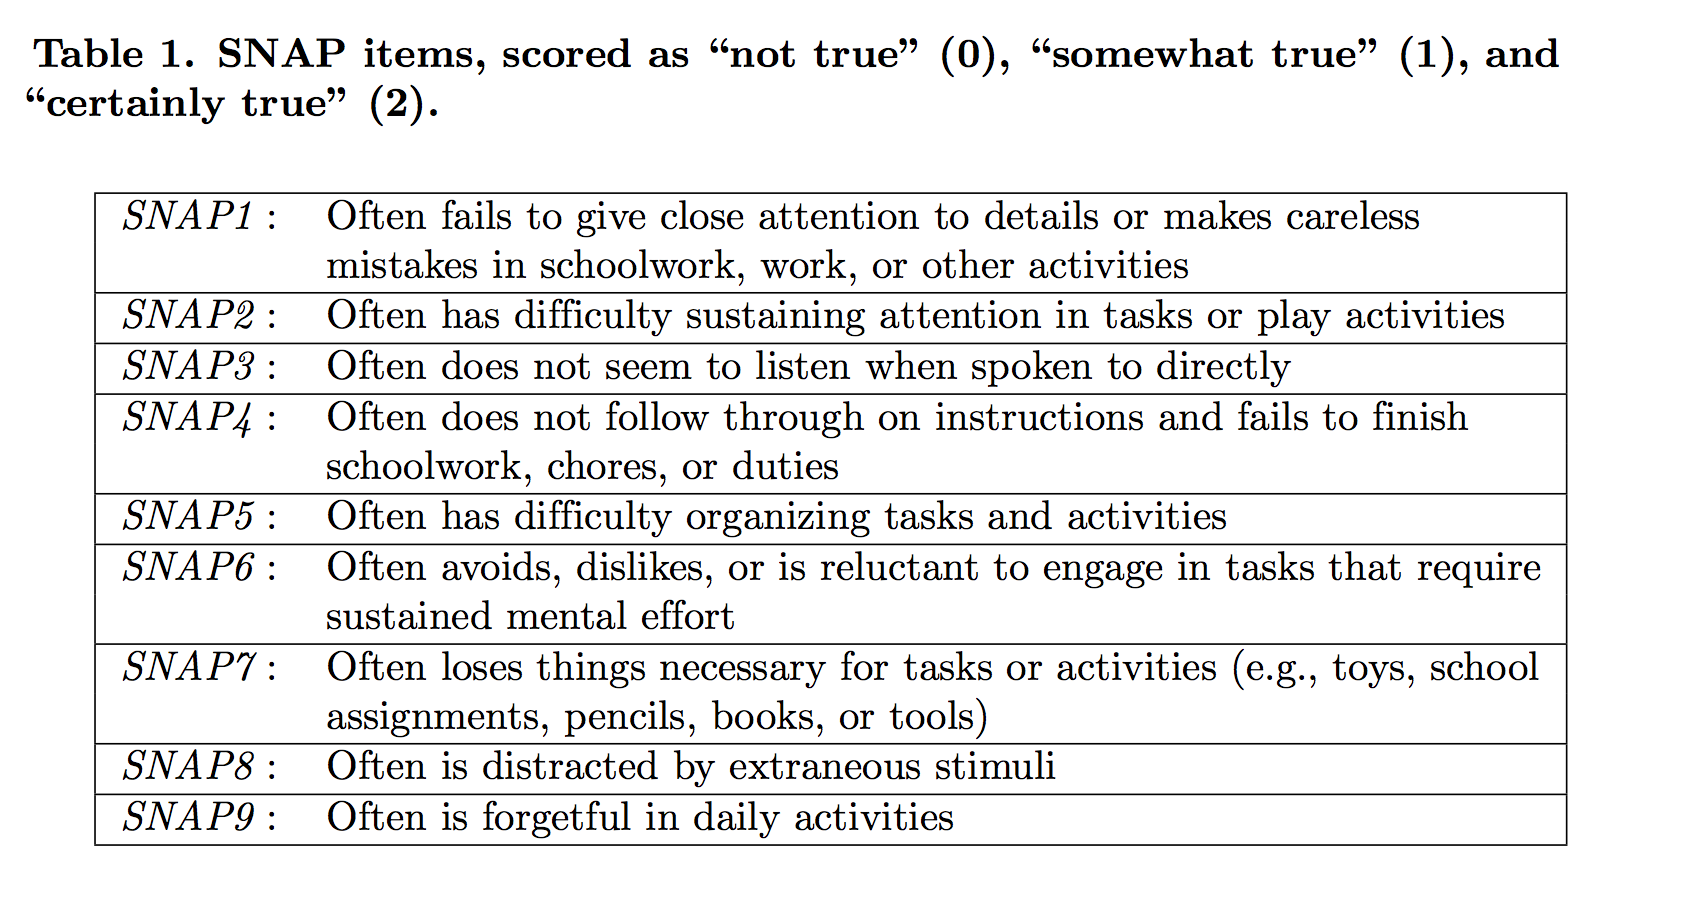

In [2]:
from IPython.display import Image
Image("../images/tab_1_SNAP_items.png")

# Tools being used (and their version) 

In [3]:
%matplotlib inline

import os
import os.path as op
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
import csv
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz 
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from io import StringIO
import statsmodels.formula.api as smf
from rpy2.robjects import pandas2ri, r # fpr reading .sav files via rpy2 and r-foreign
# from boruta import BorutaPy

import nilearn
import sklearn
import matplotlib
import xgboost as xgb
import statsmodels as sm
import rpy2
#import boruta

from rpy2.robjects import pandas2ri, r

print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('scipy: %s' % scipy.__version__)
print('nilearn: %s' % nilearn.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('seaborn: %s' % sns.__version__)
print('xgboost: %s' % xgb.__version__)
print('graphviz: %s' % graphviz.__version__)
print('statsmodels: %s' % sm.__version__)
print('rpy2: %s' % rpy2.__version__)

/Users/arvid/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


numpy: 1.12.1
pandas: 0.20.3
scipy: 0.19.1
nilearn: 0.3.1
matplotlib: 2.0.2
sklearn: 0.19.0
seaborn: 0.8.1
xgboost: 0.6
graphviz: 0.7.1
statsmodels: 0.8.0
rpy2: 2.8.5


In [4]:
# Relevant files
# The original SPSS file was provided to AJL and preprocessed by 01_prediction.ipynb

# Read preprocessed data file (.csv) and explore data

In [5]:
# Produced by 01_preparation.ipynb:
fnF = "../data/inattention_nomiss_2491x12.csv"
df = pd.read_csv(fnF)
print(df.columns)
df.head()

Index(['gender', 'grade', 'SNAP1', 'SNAP2', 'SNAP3', 'SNAP4', 'SNAP5', 'SNAP6',
       'SNAP7', 'SNAP8', 'SNAP9', 'aveBinned'],
      dtype='object')


,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,aveBinned
0,0,2,0,0,0,0,0,0,0,0,0,2
1,0,2,0,0,1,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,0,1
3,0,2,0,0,0,0,0,0,0,0,0,1
4,0,2,0,0,0,0,0,0,0,0,0,1


In [6]:
df.tail()

,gender,grade,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9,aveBinned
2486,1,4,1,1,1,1,0,1,0,1,0,1
2487,1,4,0,0,0,0,0,0,0,0,0,1
2488,1,4,1,0,0,0,0,0,0,0,0,1
2489,1,4,1,1,0,0,0,0,1,1,1,1
2490,1,4,1,0,0,0,0,0,0,0,0,0


In [7]:
def sc(snap):
    s = pd.DataFrame(pd.value_counts(df[snap]))
    return s

pd.concat([sc('SNAP1'),sc('SNAP2'),sc('SNAP3'),
           sc('SNAP4'),sc('SNAP5'),sc('SNAP6'),
           sc('SNAP7'),sc('SNAP8'),sc('SNAP9')], axis=1)

,SNAP1,SNAP2,SNAP3,SNAP4,SNAP5,SNAP6,SNAP7,SNAP8,SNAP9
0,2167,2205,2292,2308,2279,2284,2405,1873,2229
1,278,236,184,167,181,175,74,522,232
2,46,50,15,16,31,32,12,96,30


# Percentage of children obtaining a given item response from their teachers 

**SNAP1**

In [8]:
snap1_freq = pd.crosstab(index=df["gender"],columns=df["SNAP1"], margins=True)
snap1_freq.columns = ["Not true", "Somewhat true", "Certainly true","rowtotal"]
snap1_freq.index= ["Girls","Boys","coltotal"]
snap1_freq # Include row and column totals

,Not true,Somewhat true,Certainly true,rowtotal
Girls,1186,97,16,1299
Boys,981,181,30,1192
coltotal,2167,278,46,2491


In [9]:
df1 = 100*snap1_freq.div(snap1_freq["rowtotal"],axis=0)
df1.round(2)

,Not true,Somewhat true,Certainly true,rowtotal
Girls,91.30,7.47,1.23,100.0
Boys,82.30,15.18,2.52,100.0
coltotal,86.99,11.16,1.85,100.0


In [10]:
def snap_freq(i):
    snap = 'SNAP%d' % (i)
    freq = pd.crosstab(index=df["gender"],columns=df[snap], margins=True)
    freq.columns = ["NotTrue", "SomewhatTrue", "CertainlyTrue","rowtotal"]
    freq.index= ["Girls","Boys","coltotal"] 
    
    columns = ['N_All', 'N_Girls', 'N_Boys', 'S_All', 'S_Girls', 'S_Boys', 'C_All', 'C_Girls', 'C_Boys']
    index = [snap]
    df_ = pd.DataFrame(index=index, columns=columns)
    df_ = 100*freq.div(freq["rowtotal"],axis=0)
    N_All = df_.NotTrue['coltotal']
    N_Girls = df_.NotTrue['Girls']
    N_Boys = df_.NotTrue['Boys']
    S_All = df_.SomewhatTrue['coltotal']
    S_Girls = df_.SomewhatTrue['Girls']
    S_Boys = df_.SomewhatTrue['Boys']
    C_All = df_.CertainlyTrue['coltotal']
    C_Girls = df_.CertainlyTrue['Girls']
    C_Boys = df_.CertainlyTrue['Boys']
    return freq, df_, N_All, N_Girls, N_Boys, S_All, S_Girls, S_Boys, C_All, C_Girls, C_Boys 

In [11]:
index = ['SNAP1','SNAP2','SNAP3','SNAP4', 'SNAP5','SNAP6','SNAP7','SNAP8','SNAP9']
columns = ['N_All', 'N_Girls', 'N_Boys', 'S_All', 'S_Girls', 'S_Boys', 'C_All', 'C_Girls', 'C_Boys']
df_ = pd.DataFrame(index=index, columns=columns)
df_ = df_.fillna(0) # with 0s rather than NaNs
print(df_.shape)

(9, 9)


In [12]:
for i in range(9):
    freq, sf, N_all, N_Girls, N_Boys, S_all, S_Girls, S_Boys, C_all, C_Girls, C_Boys = snap_freq(i+1)
    df_.iloc[i,0:] = [N_all, N_Girls, N_Boys, S_all, S_Girls, S_Boys, C_all, C_Girls, C_Boys]
    
df_.round(1)

,N_All,N_Girls,N_Boys,S_All,S_Girls,S_Boys,C_All,C_Girls,C_Boys
SNAP1,87.0,91.3,82.3,11.2,7.5,15.2,1.8,1.2,2.5
SNAP2,88.5,94.1,82.5,9.5,5.5,13.8,2.0,0.5,3.7
SNAP3,92.0,96.7,86.9,7.4,3.1,12.1,0.6,0.2,1.0
SNAP4,92.7,96.2,88.8,6.7,3.5,10.2,0.6,0.2,1.1
SNAP5,91.5,96.1,86.5,7.3,3.5,11.4,1.2,0.5,2.1
SNAP6,91.7,96.3,86.7,7.0,3.3,11.1,1.3,0.4,2.3
SNAP7,96.5,98.5,94.4,3.0,1.2,4.9,0.5,0.3,0.7
SNAP8,75.2,84.4,65.1,21.0,14.1,28.4,3.9,1.5,6.5
SNAP9,89.5,93.4,85.2,9.3,6.2,12.7,1.2,0.4,2.1


In [13]:
print(df.shape)
pd.DataFrame(pd.value_counts(df['gender']))

(2491, 12)


,gender
0,1299
1,1192


In [14]:
txt = df_.round(1).to_latex(bold_rows=False)
print(txt)
text_file = open('../manuscript/table2.txt', 'w')
text_file.write(txt)
text_file.close()

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  N\_All &  N\_Girls &  N\_Boys &  S\_All &  S\_Girls &  S\_Boys &  C\_All &  C\_Girls &  C\_Boys \\
\midrule
SNAP1 &   87.0 &     91.3 &    82.3 &   11.2 &      7.5 &    15.2 &    1.8 &      1.2 &     2.5 \\
SNAP2 &   88.5 &     94.1 &    82.5 &    9.5 &      5.5 &    13.8 &    2.0 &      0.5 &     3.7 \\
SNAP3 &   92.0 &     96.7 &    86.9 &    7.4 &      3.1 &    12.1 &    0.6 &      0.2 &     1.0 \\
SNAP4 &   92.7 &     96.2 &    88.8 &    6.7 &      3.5 &    10.2 &    0.6 &      0.2 &     1.1 \\
SNAP5 &   91.5 &     96.1 &    86.5 &    7.3 &      3.5 &    11.4 &    1.2 &      0.5 &     2.1 \\
SNAP6 &   91.7 &     96.3 &    86.7 &    7.0 &      3.3 &    11.1 &    1.3 &      0.4 &     2.3 \\
SNAP7 &   96.5 &     98.5 &    94.4 &    3.0 &      1.2 &     4.9 &    0.5 &      0.3 &     0.7 \\
SNAP8 &   75.2 &     84.4 &    65.1 &   21.0 &     14.1 &    28.4 &    3.9 &      1.5 &     6.5 \\
SNAP9 &   89.5 &     93.4 &    85.2 &    9.3 &      6.2 &

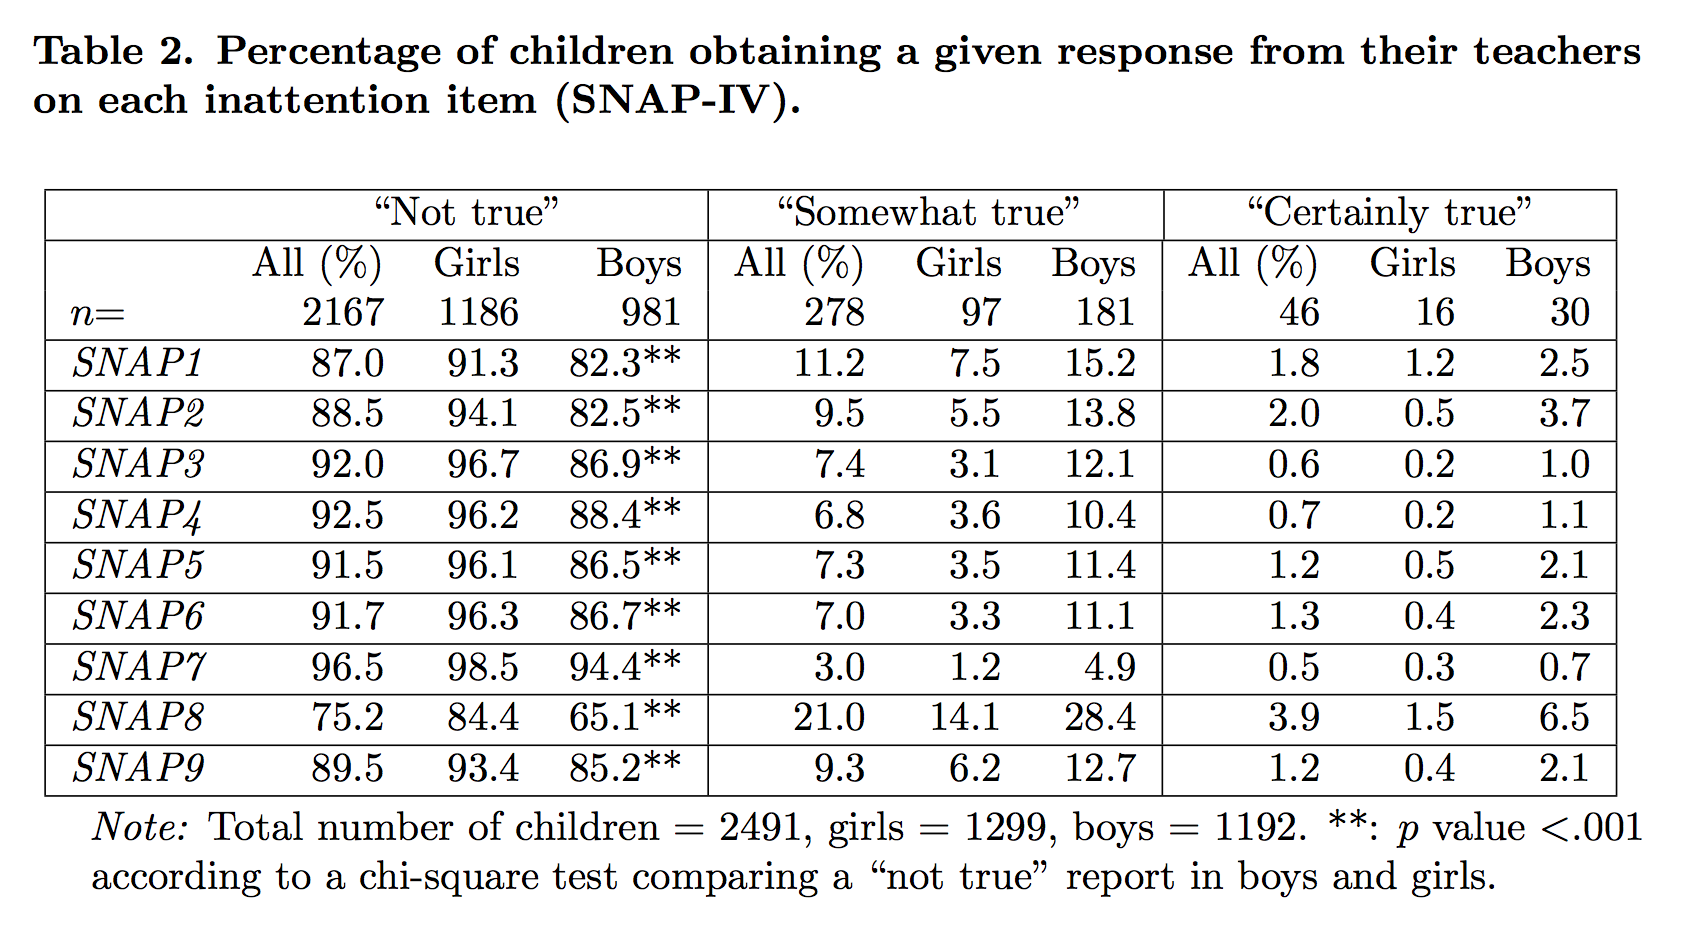

In [15]:
from IPython.display import Image
Image("../images/tab_2_SNAP_responses.png")

In [16]:
pd.DataFrame(df.groupby('gender')['SNAP1'].value_counts())

SNAP1
gender SNAP1       
0      0       1186
       1         97
       2         16
1      0        981
       1        181
       2         30

# Assessment of feature importance in academic achievement prediction

## Multinomial logistic regression

The multinomial logistic regression analysis included the following set of variables on a nominal level: the three levels of academic achievement scores as outcome variable, and 
 {\it gender}, primary school class level ({\it grade}), and  teacher reports on the nine inattention items {\it SNAP1},$\ldots$,{\it SNAP9} as predictors. 
Generally, the multinomial logistic regression model relates a set of explanatory variables $x_1, \ldots, x_p$ to a set of log-odds, $\log(\pi_2/\pi_1), \ldots \log(\pi_J/\pi_1)$ according to

\begin{equation}
\label{eq_MLR}
\log(\pi_j/\pi_1) = \beta_{j0} + \beta_{j1} x_1 + \cdots + \beta_{jp} x_p
\end{equation}

for $j=2,\ldots,J$. Here, $j = 1$ represents the base level category, $\pi_j = P(\mbox{academic achievement level} = j)$, $\pi_j/\pi_{j'}$ denotes the odds of category $j$ relative 
to $j'$ \textcolor{blue}{(i.e. odds ratio, OR)}, and $\sum_{j=1}^J \pi_j = 1$ (see e.g. \cite{Bilder2015} for details).
In our case, we let the base level category $j=1$ be the {\it low} mean academic achievement, meaning that the {\it low} was compared separately to 
the {\it medium} and {\it high} categories.}
For computations we used **mnlogit( )** from the **statsmodels.formula.api**.



In [17]:
formula = 'aveBinned ~ gender+grade+SNAP1+SNAP2+SNAP3+SNAP4+SNAP5+SNAP6+SNAP7+SNAP8+SNAP9'
mdl = smf.mnlogit(formula, df)
mdl_fit = mdl.fit()
mdl_fit.summary()

Optimization terminated successfully.
         Current function value: 1.048289
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              aveBinned   No. Observations:                 2491
Model:                        MNLogit   Df Residuals:                     2467
Method:                           MLE   Df Model:                           22
Date:                Fri, 29 Sep 2017   Pseudo R-squ.:                 0.04580
Time:                        23:52:18   Log-Likelihood:                -2611.3
converged:                       True   LL-Null:                       -2736.6
                                        LLR p-value:                 1.058e-40
===============================================================================
aveBinned=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7362      0.198      3.722      0.000       0.349       1.124
gender         -0.2361      0.103     -2.291      0.022      -0.438      -0.034
grade          -0.1464      0.064     -2.281      0.023      -0.272      -0.021
SNAP1          -0.0052      0.137     -0.038      0.970      -0.273       0.263
SNAP2          -0.6217      0.192     -3.244      0.001      -0.997      -0.246
SNAP3           0.0596      0.193      0.309      0.757      -0.318       0.437
SNAP4           0.2104      0.237      0.889      0.374      -0.253       0.674
SNAP5           0.0082      0.218      0.038      0.970      -0.420       0.436
SNAP6          -0.1886      0.202     -0.935      0.350      -0.584       0.207
SNAP7           0.1555      0.260      0.598      0.550      -0.354       0.665
SNAP8          -0.2846      0.125     -2.272      0.023      -0.530      -0.039
SNAP9          -0.0883      0.160     -0.552      0.581      -0.402       0.225
-------------------------------------------------------------------------------
aveBinned=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7817      0.202      3.876      0.000       0.386       1.177
gender         -0.5111      0.106     -4.832      0.000      -0.718      -0.304
grade          -0.0690      0.065     -1.054      0.292      -0.197       0.059
SNAP1          -0.4996      0.178     -2.800      0.005      -0.849      -0.150
SNAP2          -0.9276      0.262     -3.546      0.000      -1.440      -0.415
SNAP3          -0.0931      0.245     -0.379      0.704      -0.574       0.388
SNAP4           0.1803      0.315      0.573      0.567      -0.436       0.797
SNAP5           0.4561      0.270      1.690      0.091      -0.073       0.985
SNAP6          -0.7374      0.286     -2.577      0.010      -1.298      -0.177
SNAP7          -0.2833      0.431     -0.657      0.511      -1.128       0.562
SNAP8          -0.6049      0.146     -4.157      0.000      -0.890      -0.320
SNAP9          -0.1400      0.190     -0.735      0.462      -0.513       0.233
===============================================================================
"""

In [18]:
estimM = mdl_fit.params[0].round(2)
estimH = mdl_fit.params[1].round(2)
pvalM = mdl_fit.pvalues[0].round(3)
pvalH = mdl_fit.pvalues[1].round(3)
zM = mdl_fit.tvalues[0].round(2)
zH = mdl_fit.tvalues[1].round(2)


In [19]:
# Take the exponential of each of the coefficients to 
# generate the odds ratios. 
# This tells you how a 1 unit increase or decrease in a variable 
# affects the odds of being admitted.
# print(np.exp(mdl_fit.params))
print("Odds Ratio:")
OR = pd.DataFrame(np.exp(mdl_fit.params)).round(2)
OR.columns = ['aveBinned=2', 'aveBinned=3']
OR

Odds Ratio:


,aveBinned=2,aveBinned=3
Intercept,2.09,2.19
gender,0.79,0.60
grade,0.86,0.93
SNAP1,0.99,0.61
SNAP2,0.54,0.40
SNAP3,1.06,0.91
SNAP4,1.23,1.20
SNAP5,1.01,1.58
SNAP6,0.83,0.48
SNAP7,1.17,0.75


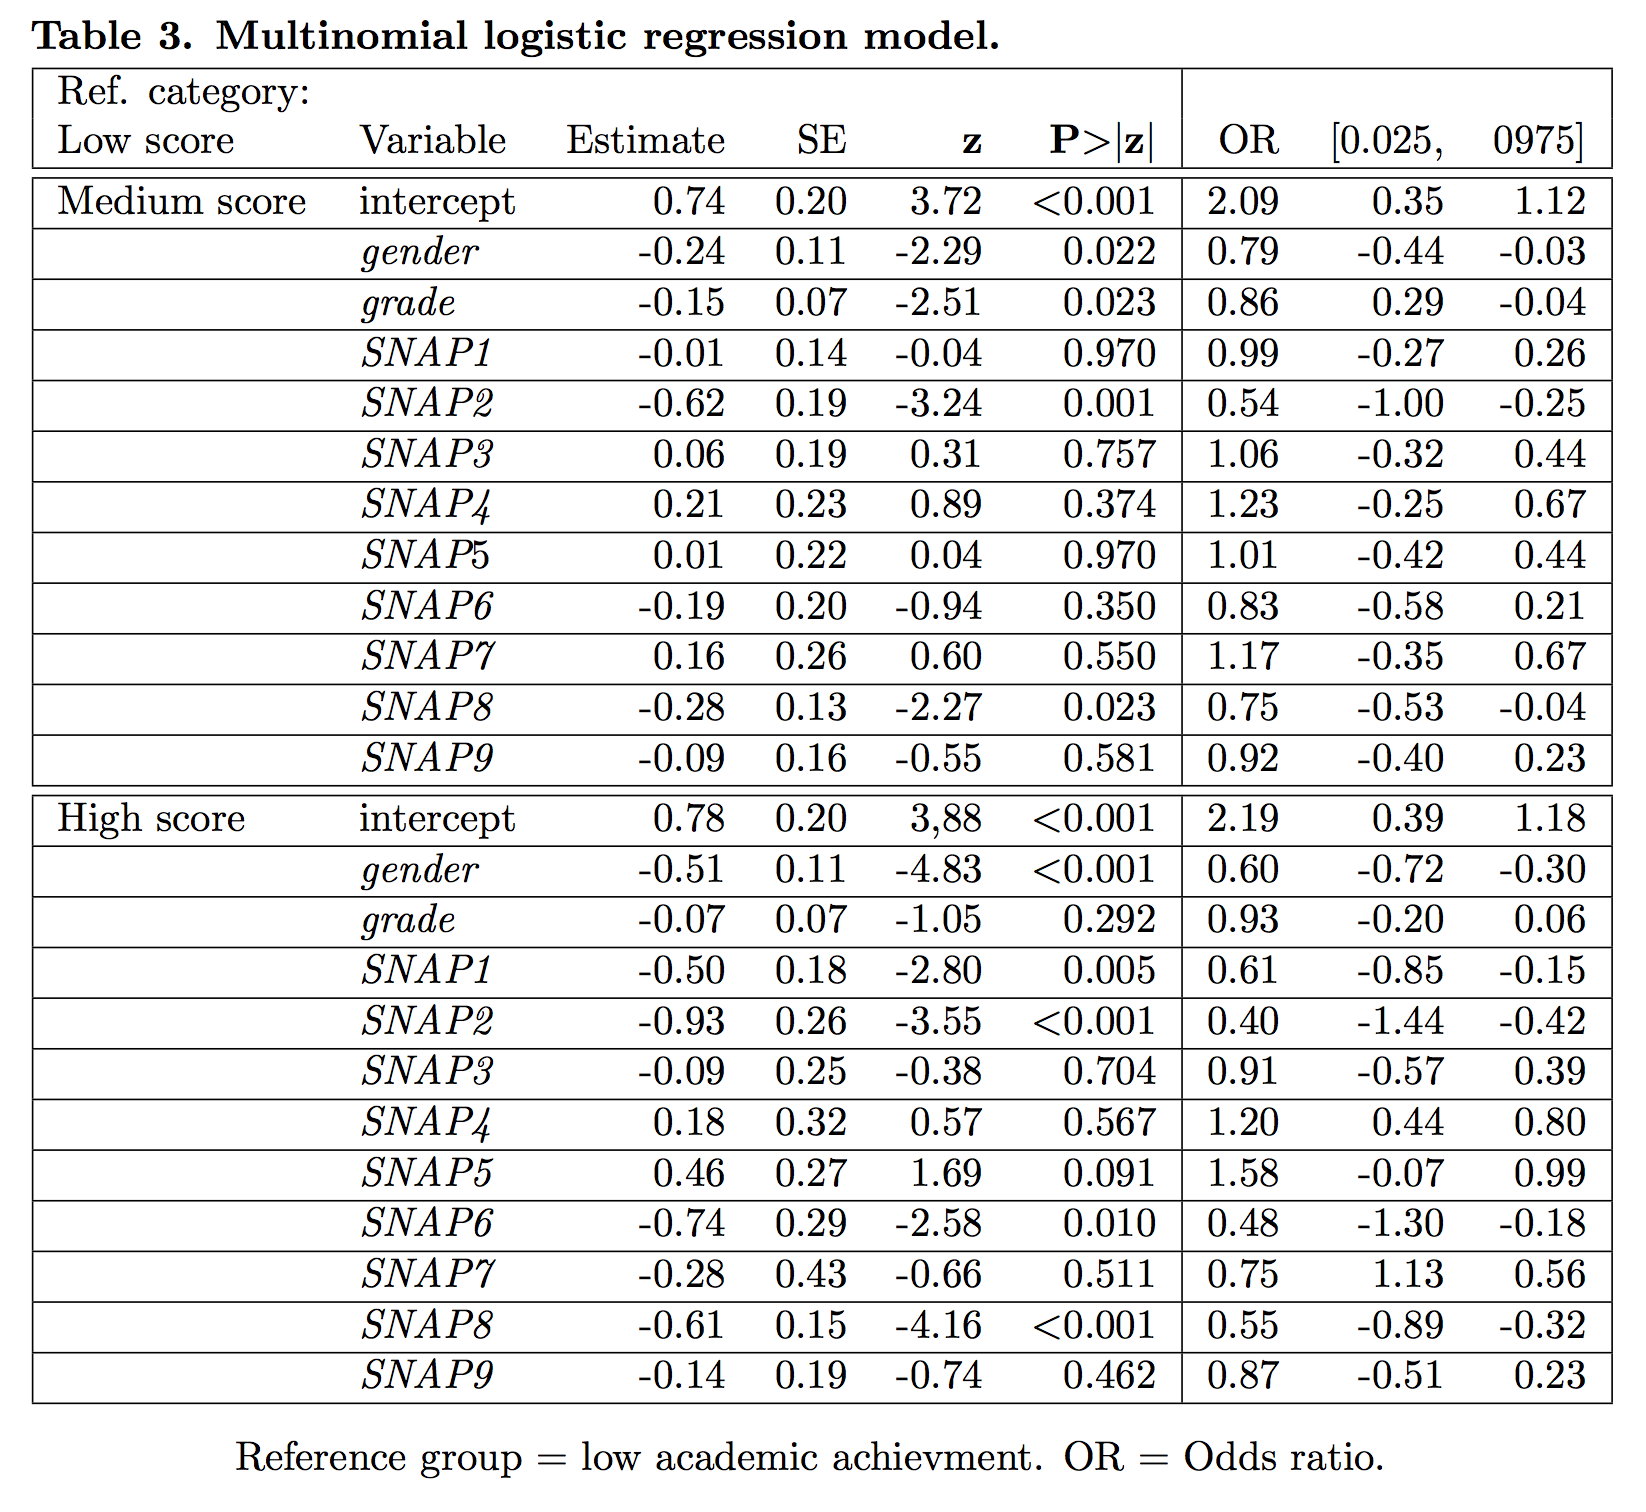

In [20]:
from IPython.display import Image
Image("../images/tab_3_MLR.png")

## CART

[2 0 1]


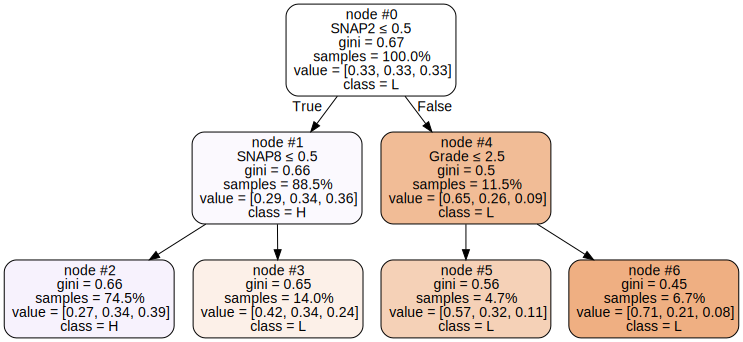

In [21]:
# export_graphviz
# $ dot -Tps tree.dot -o tree.ps      (PostScript format)
# dot -Tpng /tmp/inattention_tree -o tree.png

# dfX = pd.read_csv(fnC)


X_train = df.loc[:, df.columns != 'aveBinned'] 
y_train = df.loc[:, 'aveBinned']
print(y_train.unique())

feature_names = ['Gender', 'Grade', 'SNAP1', 'SNAP2', 'SNAP3', 'SNAP4', 'SNAP5', 'SNAP6', 'SNAP7', 'SNAP8', 'SNAP9']

clf = sklearn.tree.DecisionTreeClassifier(criterion='gini',max_depth=2)
clf = clf.fit(X_train, y_train)
# tree.export_graphviz(clf,out_file='/tmp/tree.dot')
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['L', 'M', 'H'],   
                         filled=True, rounded=True, label = 'all', 
                         node_ids = True, proportion = True,
                         precision = 2, leaves_parallel = False,
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [22]:
graph.render("../manuscript/Figs/inattention_CART")

'../manuscript/Figs/inattention_CART.pdf'

## Random Forest feature importance

**Select predictors X and outcome y and build a RandomForestClassifier**

In [23]:
X = df.loc[:, df.columns != 'aveBinned'] 
y = df.loc[:, 'aveBinned']
print(X.shape)
print(X.columns)

(2491, 11)
Index(['gender', 'grade', 'SNAP1', 'SNAP2', 'SNAP3', 'SNAP4', 'SNAP5', 'SNAP6',
       'SNAP7', 'SNAP8', 'SNAP9'],
      dtype='object')


In [24]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=10000, max_features=None, random_state=0)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

**Compute and display the feature importance from the forest**

Feature ranking:
1. feature 3 [SNAP2] (0.137476)
2. feature 9 [SNAP8] (0.119970)
3. feature 1 [grade] (0.117769)
4. feature 10 [SNAP9] (0.105613)
5. feature 2 [SNAP1] (0.103511)
6. feature 6 [SNAP5] (0.080683)
7. feature 4 [SNAP3] (0.075487)
8. feature 7 [SNAP6] (0.073645)
9. feature 0 [gender] (0.071161)
10. feature 5 [SNAP4] (0.068278)
11. feature 8 [SNAP7] (0.046407)


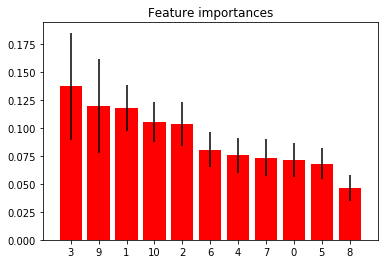

Top 5 feature ranking:


,connection,feature no.,importance
1,SNAP2,3,0.137476
2,SNAP8,9,0.119970
3,grade,1,0.117769
4,SNAP9,10,0.105613
5,SNAP1,2,0.103511


In [25]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

n_ = X.shape[1]
#n_ = 10
for f in range(n_):
    print("%d. feature %d [%s] (%f)" % (f+1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


print("Top 5 feature ranking:")

top = 5
top5 = indices[range(top)]  # Feature importances with Random Forest

X5 = X.iloc[:, top5]
c1 = pd.DataFrame(X.columns[top5], index = list(range(1, top+1)), columns = ['connection'])
c2 = pd.DataFrame(indices[range(top)], index = list(range(1, top+1)), columns = ['feature no.'])
c3 = pd.DataFrame(importances[indices[range(top)]], index = list(range(1, top+1)), columns = ['importance'])
pd.concat([c1, c2, c3], axis=1)

Index(['SNAP2', 'SNAP8', 'grade', 'SNAP9', 'SNAP1', 'SNAP5', 'SNAP3', 'SNAP6',
       'gender', 'SNAP4', 'SNAP7'],
      dtype='object')


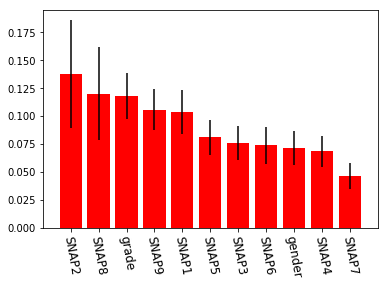

In [26]:
# Plot the top ranked feature importances of the forest

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

top_n = 11
topn = indices[range(top_n)]  # Feature importances with Random Forest

Xn = X.iloc[:, topn]

print(Xn.columns)
plt.figure()
plt.bar(range(Xn.shape[1]), importances[topn],
       color="r", yerr=std[topn], align="center")
labels = ['gender', 'grade', 'SNAP1', 'SNAP2', 'SNAP3', 'SNAP4', 'SNAP5', 'SNAP6', 'SNAP7', 'SNAP8', 'SNAP9']
ranked_labels = [labels[i] for i in topn]
plt.xticks(range(top_n), ranked_labels, rotation = 280, fontsize=12)
plt.xlim([-1, Xn.shape[1]])
thisfig_ = '../manuscript/Figs/random_forest_feature_importance.pdf'
plt.savefig(thisfig_, bbox_inches='tight')
plt.show()

# Organization of X and y before prediction with $k$-fold cross-validation

In [27]:
Xp = df.loc[:, ['SNAP2', 'SNAP8', 'grade', 'gender']]
y = df.loc[:, 'aveBinned']
y = y.as_matrix().ravel()
print(np.unique(y))
Xp.columns

[0 1 2]


Index(['SNAP2', 'SNAP8', 'grade', 'gender'], dtype='object')

# Prediction (with MLR, MLP, XGB, SVM, KNN, Voting) using $k$-fold cross-validation

In [28]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing


rs = 42 # random_state (42)
hls = 3 # MLP hidden layer size (3 or 4)
# https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric
myaverage = 'weighted' # For multilabel classification  'micro', 'macro', 'samples', 'weighted'
# see: https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric

# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that 
# trains using Backpropagation.

# So what about size of the hidden layer(s)--how many neurons? 
# There are some empirically-derived rules-of-thumb, of these, the most 
# commonly relied on is 'the optimal size of the hidden layer is usually 
# between the size of the input and size of the output layers'. 
# Jeff Heaton, author of Introduction to Neural Networks in Java offers a few more.
#
# In sum, for most problems, one could probably get decent performance (even without 
# a second optimization step) by setting the hidden layer configuration using j
# ust two rules: 
#  (i) number of hidden layers equals one; and 
# (ii) the number of neurons in that layer is the mean of the neurons in the 
#      input and output layers.


# Compute the precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
# fp the number of false positives. The precision is intuitively the ability of the 
# classifier not to label as positive a sample that is negative.

# Compute the recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and 
# fn the number of false negatives. The recall is intuitively the ability of the 
# classifier to find all the positive samples.

# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is:
#    F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

pipe_clf1 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf1', LogisticRegression(C=1., solver='saga', n_jobs=1, 
                                multi_class='multinomial', random_state=rs))])

pipe_clf2 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf2', MLPClassifier(hidden_layer_sizes=(hls, ),   # =(100, )  ; =(4, )
                          activation='relu', solver='adam',
                          alpha=0.0001, batch_size='auto', learning_rate='constant',
                          learning_rate_init=0.001, power_t=0.5, max_iter=5000,
                          shuffle=True, random_state=rs, tol=0.0001, verbose=False,
                          warm_start=False, momentum=0.9, nesterovs_momentum=True,
                          early_stopping=False, validation_fraction=0.1,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08))])

pipe_clf3 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf3', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                           gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                           min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
                           objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=rs, silent=True, subsample=1))])
     
pipe_clf4 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf4', SVC(C=1.0, probability=True, random_state=rs))])
#    ('clf4', SVC(C=1.0, random_state=rs))])
    
pipe_clf5 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf5', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', 
                           leaf_size=30, p=2, metric='minkowski', 
                           metric_params=None, n_jobs=1))])

pipe_clf_vote =  Pipeline([
#    ('scl', StandardScaler()),
    ('clf_vote', VotingClassifier(
        estimators=[('lr', pipe_clf1), 
                 ('mlp', pipe_clf2),
                 ('rf', pipe_clf3),
                 ('svc', pipe_clf4),
                 ('knn', pipe_clf5)],
     voting = 'soft'))])
#     voting = 'hard'))])

scores1_acc, scores2_acc, scores3_acc, scores4_acc, scores5_acc, scores_vote_acc = [], [], [], [], [], []
scores1_pre, scores2_pre, scores3_pre, scores4_pre, scores5_pre, scores_vote_pre = [], [], [], [], [], []
scores1_rec, scores2_rec, scores3_rec, scores4_rec, scores5_rec, scores_vote_rec = [], [], [], [], [], []
scores1_f1, scores2_f1, scores3_f1, scores4_f1, scores5_f1, scores_vote_f1 = [], [], [], [], [], []

n_splits = 10  # k=10
   
k=1
for train_index, test_index in \
StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs).split(X,y):
    print("Fold number:", k)
    X_train, X_test = Xp.iloc[train_index], Xp.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    #clf1 = LogisticRegression
    print(" - LogisticRegression")
    pipe_clf1.fit(X_train, y_train)
    scores1_acc.append(accuracy_score(y_test, pipe_clf1.predict(X_test)))
    scores1_pre.append(precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_rec.append(recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_f1.append(f1_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    #print("LR predicted:\n", list(pipe_clf1.predict(X_test)))
    
    #clf2 = MLPClassifier
    print(" - MLPClassifier")
    pipe_clf2.fit(X_train, y_train)
    scores2_acc.append(accuracy_score(y_test, pipe_clf2.predict(X_test)))
    scores2_pre.append(precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_rec.append(recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_f1.append(f1_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    #print("MLP predicted:\n", list(pipe_clf2.predict(X_test)))
    
    #clf3 = RandomForestClassifier
    #print(" - RandomForestClassifier")
    #clf3 = XGBoost
    print(" - XGBoost")
    pipe_clf3.fit(X_train, y_train)
    scores3_acc.append(accuracy_score(y_test, pipe_clf3.predict(X_test)))
    scores3_pre.append(precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_rec.append(recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_f1.append(f1_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    #print("RF predicted:\n", list(pipe_clf3.predict(X_test)))
    #print("XGB predicted:\n", list(pipe_clf3.predict(X_test)))
    
    #clf4 = svm.SVC()
    print(" - svm/SVC")
    pipe_clf4.fit(X_train, y_train)
    scores4_acc.append(accuracy_score(y_test, pipe_clf4.predict(X_test)))
    scores4_pre.append(precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_rec.append(recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_f1.append(f1_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    #print("SVM predicted:\n", list(pipe_clf4.predict(X_test)))
    
    #clf5 = KNeighborsClassifier
    print(" - KNN")
    pipe_clf5.fit(X_train, y_train)
    scores5_acc.append(accuracy_score(y_test, pipe_clf5.predict(X_test)))
    scores5_pre.append(precision_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_rec.append(recall_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_f1.append(f1_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    #print("KNN predicted:\n", list(pipe_clf5.predict(X_test)))
    
    #clf_vote = VotingClassifier
    print(" - VotingClassifier")
    pipe_clf_vote.fit(X_train, y_train)
    scores_vote_acc.append(accuracy_score(y_test, pipe_clf_vote.predict(X_test)))
    scores_vote_pre.append(precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_rec.append(recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_f1.append(f1_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    k=k+1
    
print('\nPredictors:')
print('Xp.columns = %s' % list(Xp.columns))

print('\nOutcome:')
# print(pd.qcut(_df['ave'], 3).head(0))
print(np.unique(y))

print('\nSome hyperparameters:')
print("MLP hidden_layer_size = %d" % (hls))
print("random_state = %d" % (rs))
print("score average = '%s'" % (myaverage))

print("\nMLR : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores1_acc), np.std(scores1_acc), n_splits))
print("MLP: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores2_acc), np.std(scores2_acc), n_splits))
print("XGB : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("SVM: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores4_acc), np.std(scores4_acc), n_splits))
print("KNN: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores5_acc), np.std(scores5_acc), n_splits))
print("Voting: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_acc), np.std(scores_vote_acc), n_splits))

print("\nMLR : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores1_pre), np.std(scores1_pre), n_splits))
print("MLP: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores2_pre), np.std(scores2_pre), n_splits))
print("XGB : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores3_pre), np.std(scores3_pre), n_splits))
print("SVM: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores4_pre), np.std(scores4_pre), n_splits))
print("KNN: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores5_pre), np.std(scores5_pre), n_splits))
print("Voting: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_pre), np.std(scores_vote_pre), n_splits))

print("\nMLR : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores1_rec), np.std(scores1_rec), n_splits))
print("MLP: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores2_rec), np.std(scores2_rec), n_splits))
print("XGB : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores3_rec), np.std(scores3_rec), n_splits))
print("SVM: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores4_rec), np.std(scores4_rec), n_splits))
print("KNN: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores5_rec), np.std(scores5_rec), n_splits))
print("Voting: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_rec), np.std(scores_vote_rec), n_splits))

print("\nMLR : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores1_f1), np.std(scores1_f1), n_splits))
print("MLP: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores2_f1), np.std(scores2_f1), n_splits))
print("XGB : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores3_f1), np.std(scores3_f1), n_splits))
print("SVM: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores4_f1), np.std(scores4_f1), n_splits))
print("KNN: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores5_f1), np.std(scores5_f1), n_splits))
print("Voting: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_f1), np.std(scores_vote_f1), n_splits))

Fold number: 1
 - LogisticRegression
    Precision: 0.40
    Recall: 0.41
 - MLPClassifier
    Precision: 0.43
    Recall: 0.44
 - XGBoost
    Precision: 0.42
    Recall: 0.42
 - svm/SVC
    Precision: 0.42
    Recall: 0.42
 - KNN
 - VotingClassifier
    Precision: 0.40
    Recall: 0.41
Fold number: 2
 - LogisticRegression
    Precision: 0.48
    Recall: 0.47
 - MLPClassifier
    Precision: 0.37
    Recall: 0.40
 - XGBoost
    Precision: 0.46
    Recall: 0.44
 - svm/SVC
    Precision: 0.47
    Recall: 0.45
 - KNN
 - VotingClassifier
    Precision: 0.42
    Recall: 0.42
Fold number: 3
 - LogisticRegression
    Precision: 0.46
    Recall: 0.45
 - MLPClassifier
    Precision: 0.43
    Recall: 0.44
 - XGBoost
    Precision: 0.48
    Recall: 0.46
 - svm/SVC
    Precision: 0.46
    Recall: 0.45
 - KNN
 - VotingClassifier
    Precision: 0.44
    Recall: 0.42
Fold number: 4
 - LogisticRegression
    Precision: 0.41
    Recall: 0.40
 - MLPClassifier
    Precision: 0.41
    Recall: 0.41
 - XGBoo

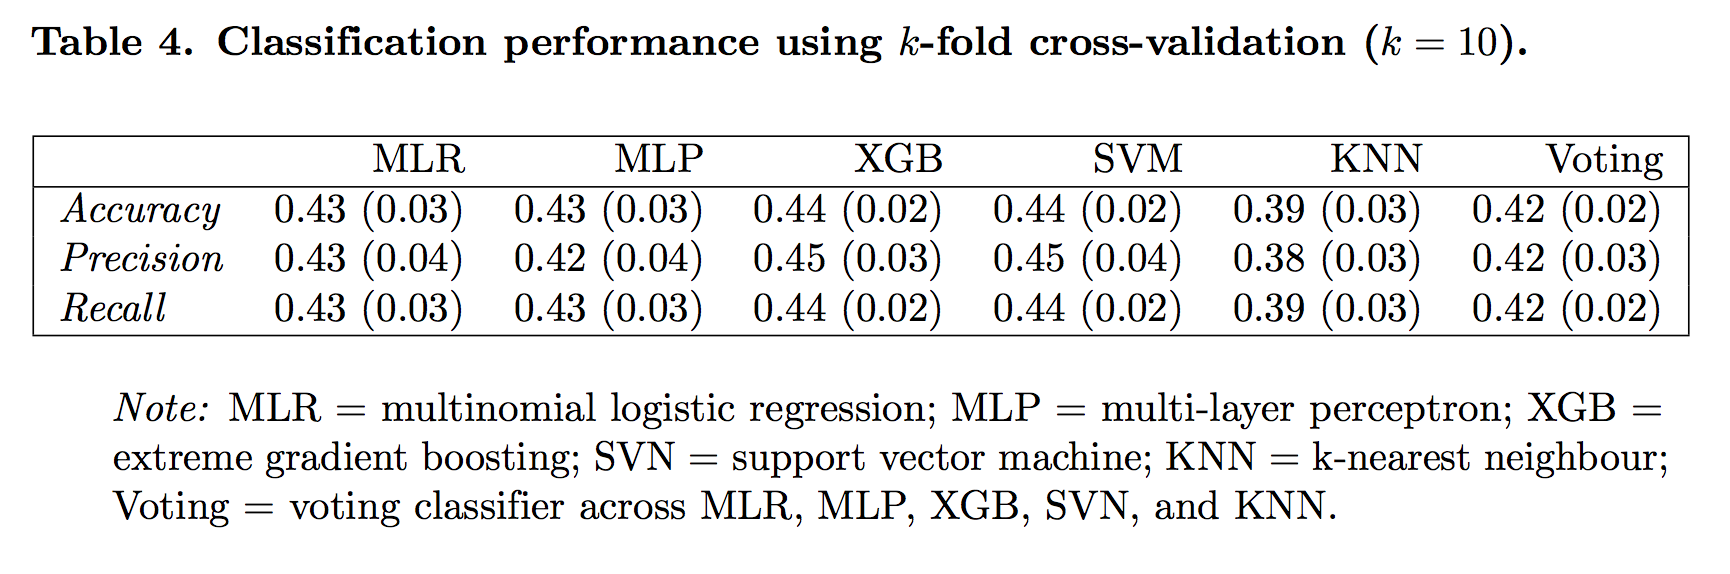

In [29]:
from IPython.display import Image
Image("../images/tab_4_prediction_with_cv.png")